### 导包+读入数据+预处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 图片输出为矢量图，保证清晰度
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, f1_score, precision_score


In [2]:
data=pd.read_csv('./clean-data.csv')
data=data.drop(['Unnamed: 0'],axis=1)
X=data.drop(['Group'],axis=1)
y=data['Group']

In [3]:
column=X.columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(data=X,columns=column)

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=None)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (132, 203)
Test shape: (33, 203)


In [5]:
def crosspredict(estimator,Xtrain,ytrain,cv):
    print("cross-validate across the entire data set")
    y_pred_cross=cross_val_predict(estimator,Xtrain,ytrain,cv=cv)
    confusion_cross=confusion_matrix(ytrain,y_pred_cross)
    a=accuracy_score(ytrain,y_pred_cross)
    p=precision_score(ytrain, y_pred_cross)
    r=recall_score(ytrain, y_pred_cross)
    f1=f1_score(ytrain, y_pred_cross)
    wf1=f1_score(ytrain, y_pred_cross, average='weighted')
    #auc=roc_auc_score(ytrain,estimator.predict_proba(Xtrain)[:,1])
    print('the confusion_matrix of the model is : \n',confusion_cross)
    print('the accuracy of the model is : ',a)
    print("the precision score of the model is : ", p)
    print("the recall score of the model is :", r)
    print('the f1_score of the model  is :',f1)
    print('the weighted_f1 of the model is :',wf1)
    print('the classification_report is :\n',classification_report(ytrain, y_pred_cross,digits=4))
    #print('the auc is :',auc)
    return a,p,r,f1,wf1

In [6]:
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin, BaseEstimator
class MyEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, model, mask) -> None:
        super().__init__()
        self.mask = mask
        self.model = model
    
    def fit(self, X, y=None):
        self.model.fit(X[self.mask],y)
        return self

    def predict(self, X):
        return self.model.predict(X[self.mask])
    
    def predict_proba(Xtrain):
        return self.model.predict_proba(Xtrain)[:,1]
        

In [10]:
from itertools import *
sel_seq_dt_mask=['APG_0101010010M','APG_0101010055P','APG_0101010063M','APG_0101010341M','APG_0101010354P']
sel_seq_rf_mask=['APG_0101010055P','APG_0101010262P','APG_0101010266P']
sel_seq_ada_mask=['APG_0101010033M','APG_0101010063M','APG_0101010067M','APG_0101010147M','APG_0101010192M', 'APG_0101010236M']
sel_seq_gb_mask=['APG_0101010002M','APG_0101010055P','APG_0101010266P','APG_0101010354P']
sel_seq_xgb_mask=['APG_0101010010M','APG_0101010037P','APG_0101010063M','APG_0101010078P','APG_0101010150P','APG_0101010230P','APG_0101010279P','APG_0101010312P','APG_0101020013M']
sel_seq_KN_mask=['APG_0101010002M', 'APG_0101010010M', 'APG_0101010052M','APG_0101010055P', 'APG_0101010176P']
sel_seq_Lightgbm_mask=['APG_0101010036M','APG_0101010078P','APG_0101010130P','APG_0101010192M','APG_0101010226P','APG_0101010242P','APG_0101010265P']
sel_seq_SVC_mask=['APG_0101010002M', 'APG_0101010010M', 'APG_0101010037P', 'APG_0101010039M', 'APG_0101010055P', 'APG_0101010143P', 'APG_0101010247P', 'APG_0101010300P', 'APG_0101010332P']
sel_seq_GNB_mask=['APG_0101010010M','APG_0101010055P','APG_0101010057M','APG_0101010081M','APG_0101010085P','APG_0101010199P','APG_0101010264P','APG_0101010279P', 'APG_0101010300P']
sel_seq_lr_mask=['APG_0101010010M','APG_0101010030M','APG_0101010041M','APG_0101010043P','APG_0101010137P','APG_0101010150P','APG_0101010152M','APG_0101010168P','APG_0101010176P','APG_0101010356P']

model_dt_fs = MyEstimator(DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=6), sel_seq_dt_mask)
model_rf_fs = MyEstimator(RandomForestClassifier(max_depth=8, n_estimators=105, n_jobs=-1,random_state=90), sel_seq_rf_mask)
model_ada_fs = MyEstimator(AdaBoostClassifier(learning_rate=0.1), sel_seq_ada_mask)
model_gb_fs = MyEstimator(GradientBoostingClassifier(loss='exponential', n_estimators=300), sel_seq_gb_mask)
model_xgb_fs = MyEstimator(XGBClassifier(booster='gblinear',learning_rate=0.3,n_estimators=10), mask=sel_seq_xgb_mask)
model_KN_fs = MyEstimator(KNeighborsClassifier(n_neighbors=3, p=1), mask=sel_seq_KN_mask)

model_Lightgbm_fs = MyEstimator(lgb.LGBMClassifier(max_depth=3, n_estimators=300), mask=sel_seq_Lightgbm_mask)
model_SVC_fs = MyEstimator(SVC(C=1, coef0=10, degree=4, kernel='poly', probability=True),mask=sel_seq_SVC_mask)
model_GNB_fs = MyEstimator(GaussianNB(),mask=sel_seq_GNB_mask)
model_lr_fs = MyEstimator(LogisticRegression(C=0.1),mask=sel_seq_lr_mask)
feature=list(set(sel_seq_dt_mask+sel_seq_rf_mask+sel_seq_ada_mask+sel_seq_GNB_mask+sel_seq_xgb_mask))
from sklearn.ensemble import VotingClassifier
model_voting= VotingClassifier([
    ("dt",model_dt_fs),
    ("rf",model_rf_fs),
    ("ada", model_ada_fs),
    ("xgb", model_xgb_fs),
    ("gnb",model_GNB_fs),
], voting="hard")
# a,b,c,d,e=crosspredict(model_voting,X,y,10)

## heatmap

In [11]:
fea=['Group']+feature

In [12]:
dataset=data[fea]

In [13]:
dataset

,Group,APG_0101010266P,APG_0101010010M,APG_0101010037P,APG_0101010192M,APG_0101010300P,APG_0101010057M,APG_0101010230P,APG_0101010312P,APG_0101010262P,...,APG_0101010236M,APG_0101010279P,APG_0101010264P,APG_0101010150P,APG_0101010081M,APG_0101020013M,APG_0101010354P,APG_0101010055P,APG_0101010147M,APG_0101010085P
0,0,17.83,0.05,1.38,12.97,1.53,19.64,0.82,0.67,0.00,...,1.98,0.52,20.01,0.54,15.09,0.37,8.52,57.97,1.96,1.93
1,0,9.59,0.23,2.13,6.67,2.44,6.69,0.12,1.44,0.00,...,0.95,0.48,13.68,0.40,1.06,0.38,7.45,34.45,1.45,4.30
2,0,9.41,0.16,1.60,5.24,1.88,8.02,3.11,1.83,0.00,...,2.20,0.52,7.04,1.08,6.05,2.17,4.60,36.36,2.11,3.93
3,0,5.89,0.14,2.54,6.02,0.79,4.31,0.94,2.76,4.81,...,4.04,0.66,7.39,0.55,14.66,0.27,4.49,42.64,0.28,13.54
4,0,6.46,0.04,4.40,10.48,1.73,8.08,0.93,1.18,0.00,...,2.10,0.90,5.08,0.88,3.97,0.88,1.65,33.02,0.77,3.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1,7.74,0.06,4.31,1.40,3.25,3.40,9.08,1.12,2.55,...,1.95,1.01,9.80,0.57,0.97,0.41,0.92,28.08,3.01,1.97
161,1,5.01,0.23,1.60,7.60,1.02,4.75,1.93,0.77,0.00,...,2.50,0.50,8.44,0.50,4.04,0.31,6.27,15.34,2.07,2.25
162,1,13.41,0.12,1.95,25.96,17.22,4.73,12.76,1.82,88.74,...,2.25,0.55,27.16,1.78,8.81,0.22,4.60,14.25,4.01,5.38
163,1,17.32,0.08,27.44,4.87,2.70,7.37,2.70,3.33,0.00,...,4.35,0.95,8.26,0.17,9.88,23.34,5.31,44.52,2.11,10.83


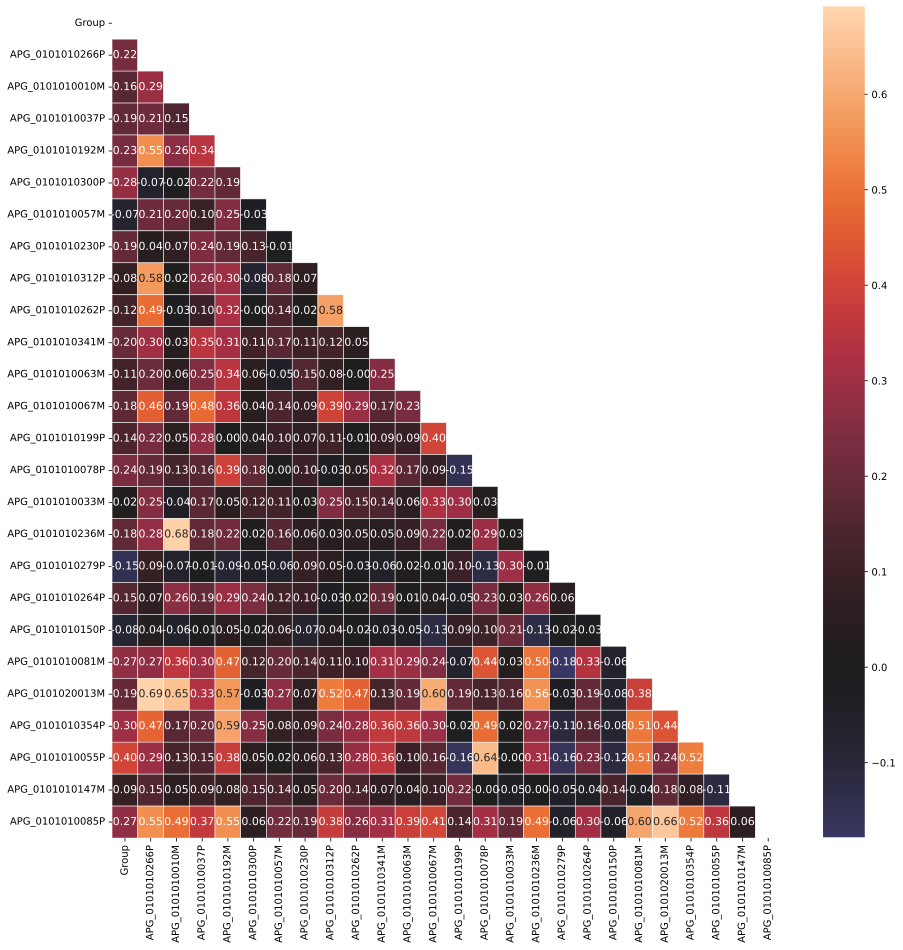

In [20]:
import seaborn as sns
corr_matrix=dataset.corr()
f, ax = plt.subplots(figsize=(15, 15))
mask=np.triu(np.ones_like(corr_matrix,dtype=bool))
sns.heatmap(corr_matrix,linewidths=0.5,mask=mask,annot=True,fmt=".2f",linecolor='white',yticklabels=True,center=0,annot_kws={"size":11})
plt.savefig('./figure/heatmap.png', dpi=500, bbox_inches='tight',facecolor='white') 
plt.show()

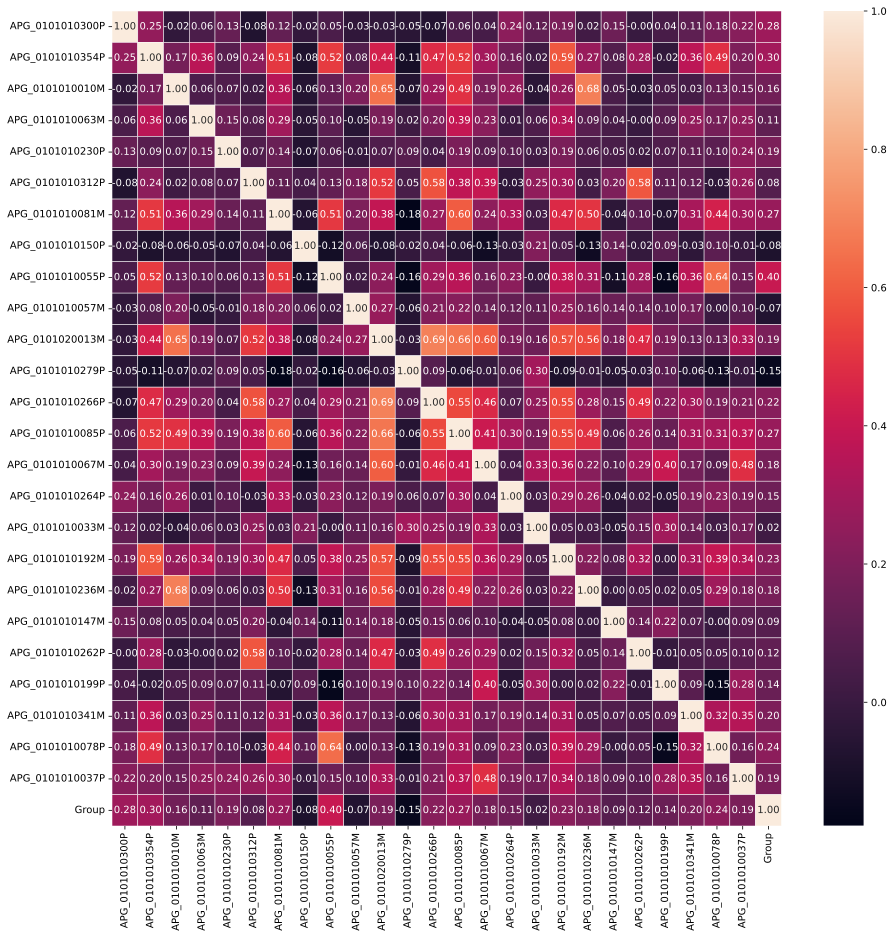

In [14]:
# import seaborn as sns
# corr_matrix=dataset.corr()
# f, ax = plt.subplots(figsize=(15, 15))
# sns.heatmap(corr_matrix,linewidths=0.5,annot=True,fmt=".2f",linecolor='white',yticklabels=True)
# plt.savefig('E:/lung_cancer_prediction/images/Private data set/heatmap.png', dpi=500, bbox_inches='tight') 
# plt.show()